
# User base segmentation (bulliten board application)

### Dashboard:

https://public.tableau.com/views/Book_2_16637039800040/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link


Research tasks:
- reveal segments based on event statistics 
- define the most promising segments
- compare traffic from different sources 

Deliverables:
- Jupyter notebook
- Dashboard


Databases:
- Event logs
- Traffic source info




## Step 1. Downloading the data

In [1]:
import pandas as pd
from scipy import stats as st
import numpy as np
import math as mth
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns 
import os 
import plotly.express as px
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import regex as re
import requests
from functools import wraps
from itertools import combinations

from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split




In [2]:
mobile_sourсes = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_soures.csv')
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')

In [3]:
mobile_sourсes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


In [4]:
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


## Step 2. Checking / cleaning

In [5]:
mobile_sourсes.head()

,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


In [6]:
mobile_sourсes.source.unique()

array(['other', 'yandex', 'google'], dtype=object)

In [7]:
# changing names of the columns
mobile_sourсes.columns = ['user_id', 'source']
mobile_dataset.head()


In [9]:
# changind names of the columns
mobile_dataset.columns = mobile_dataset.columns.str.replace('.', '_')
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  74197 non-null  object
 1   event_name  74197 non-null  object
 2   user_id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


/var/folders/n6/fppwbx8x2pg5n0hmn7vcc9dr0000gn/T/ipykernel_4886/2817600755.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  mobile_dataset.columns = mobile_dataset.columns.str.replace('.', '_')


In [10]:
# applying proper format for time data
mobile_dataset['event_time'] = pd.to_datetime(mobile_dataset['event_time'])
mobile_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.7+ MB


In [11]:
# checking time period
display(mobile_dataset['event_time'].min())
display(mobile_dataset['event_time'].max())

Timestamp('2019-10-07 00:00:00.431357')

Timestamp('2019-11-03 23:58:12.532487')

In [12]:
# checking event names
mobile_dataset.event_name.unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

In [13]:
# there is a bug, fixing names
mobile_dataset['event_name'] = mobile_dataset['event_name'].str.replace('show_contacts', 'contacts_show')
for i in range(8):
    mobile_dataset['event_name'] = mobile_dataset['event_name'].str.replace('search_'+str(i), 'search')
mobile_dataset.event_name.unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search',
       'tips_click', 'photos_show', 'favorites_add', 'contacts_call'],
      dtype=object)

In [14]:
# Checking if the data files are compatibale 
display(len(mobile_sourсes.user_id.unique()))
display(len(mobile_dataset.user_id.unique()))

4293

4293

In [15]:
# duplicates
display(mobile_sourсes.duplicated().sum())
display(mobile_dataset.duplicated().sum())

0

0

summary:
- Time range 7th of October till 3rd of November
- There are 4293 unique users

## Step 3.1 Preparing the data

We need a profile dataframe with unique users and their aggregated data


In [16]:
# Preparing DataFrame with general time info
profiles = (mobile_dataset.sort_values(by= ['user_id', 'event_time'])
            .groupby('user_id').agg({'event_time':{'first','last'}})
            .reset_index()
            )


profiles.columns = ['user_id', 'first_ts', 'last_ts']
profiles['total_duration'] = abs(profiles.last_ts - profiles.first_ts)
profiles.head()

,user_id,first_ts,last_ts,total_duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,2019-10-22 11:30:52.807203,14 days 21:51:06.817844
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769,2019-11-03 17:12:09.708771,14 days 19:37:35.859002
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35.385028,2019-11-01 14:19:17.860053,0 days 00:24:42.475025
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05.555052,2019-10-31 21:42:15.606558,12 days 23:28:10.051506
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41.263364,2019-10-29 02:17:12.342406,3 days 09:32:31.079042


In [17]:
# adding sources
profiles = profiles.merge(mobile_sourсes, on='user_id', how='left')
profiles.head()

,user_id,first_ts,last_ts,total_duration,source
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,2019-10-22 11:30:52.807203,14 days 21:51:06.817844,other
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769,2019-11-03 17:12:09.708771,14 days 19:37:35.859002,yandex
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35.385028,2019-11-01 14:19:17.860053,0 days 00:24:42.475025,yandex
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05.555052,2019-10-31 21:42:15.606558,12 days 23:28:10.051506,google
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41.263364,2019-10-29 02:17:12.342406,3 days 09:32:31.079042,yandex


In [18]:
# Creating columns for Target Action - Contact show
show_contacts = (mobile_dataset.query('event_name == "contacts_show"')
                .groupby('user_id')
                .agg(ta_count=('user_id', 'count'))
                .reset_index()
)

show_contacts.head()


,user_id,ta_count
0,00157779-810c-4498-9e05-a1e9e3cedf93,11
1,00551e79-152e-4441-9cf7-565d7eb04090,3
2,005fbea5-2678-406f-88a6-fbe9787e2268,3
3,00753c79-ea81-4456-acd0-a47a23ca2fb9,1
4,007d031d-5018-4e02-b7ee-72a30609173f,2


In [19]:
# merging  profiles and target action info
profiles['target_action'] = profiles.user_id.isin(show_contacts['user_id'])
profiles = profiles.merge(show_contacts, on='user_id', how='left')
profiles['ta_count'] = profiles.ta_count.fillna(0).astype('int32')
profiles.head()


,user_id,first_ts,last_ts,total_duration,source,target_action,ta_count
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2019-10-07 13:39:45.989359,2019-10-22 11:30:52.807203,14 days 21:51:06.817844,other,False,0
1,00157779-810c-4498-9e05-a1e9e3cedf93,2019-10-19 21:34:33.849769,2019-11-03 17:12:09.708771,14 days 19:37:35.859002,yandex,True,11
2,00463033-5717-4bf1-91b4-09183923b9df,2019-11-01 13:54:35.385028,2019-11-01 14:19:17.860053,0 days 00:24:42.475025,yandex,False,0
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,2019-10-18 22:14:05.555052,2019-10-31 21:42:15.606558,12 days 23:28:10.051506,google,False,0
4,00551e79-152e-4441-9cf7-565d7eb04090,2019-10-25 16:44:41.263364,2019-10-29 02:17:12.342406,3 days 09:32:31.079042,yandex,True,3


In [20]:
# Now - creating info re sessions. At first we need to define the time threshold between events when ine session ends and starts another
sessions = mobile_dataset.sort_values(by=['user_id', 'event_time']).reset_index(drop=True)
sessions['rank'] = sessions.groupby('user_id')['event_time'].rank(method='dense')
sessions.head(20)

,event_time,event_name,user_id,rank
0,2019-10-07 13:39:45.989359,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1.0
1,2019-10-07 13:40:31.052909,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2.0
2,2019-10-07 13:41:05.722489,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3.0
3,2019-10-07 13:43:20.735461,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4.0
4,2019-10-07 13:45:30.917502,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,5.0
5,2019-10-07 13:45:43.212340,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,6.0
6,2019-10-07 13:46:31.033718,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,7.0
7,2019-10-07 13:47:32.860234,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,8.0
8,2019-10-07 13:49:41.716617,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,9.0
9,2019-10-09 18:33:55.577963,map,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,10.0


In [21]:
# Creating columns with data on time range between events

for i in range(sessions.shape[0]):
    if sessions.loc[i,'rank'] > 1:
        sessions.loc[i,'gap'] = sessions.loc[i,'event_time'] - sessions.loc[i-1,'event_time']

sessions['gap'] = pd.to_timedelta(sessions['gap'], unit='S', errors='coerce')
sessions['gap_sec'] = sessions['gap'].dt.total_seconds().round()
sessions['gap_sec'] = sessions['gap_sec'].fillna(0)
sessions['gap_sec'] = sessions['gap_sec'].astype('int32')




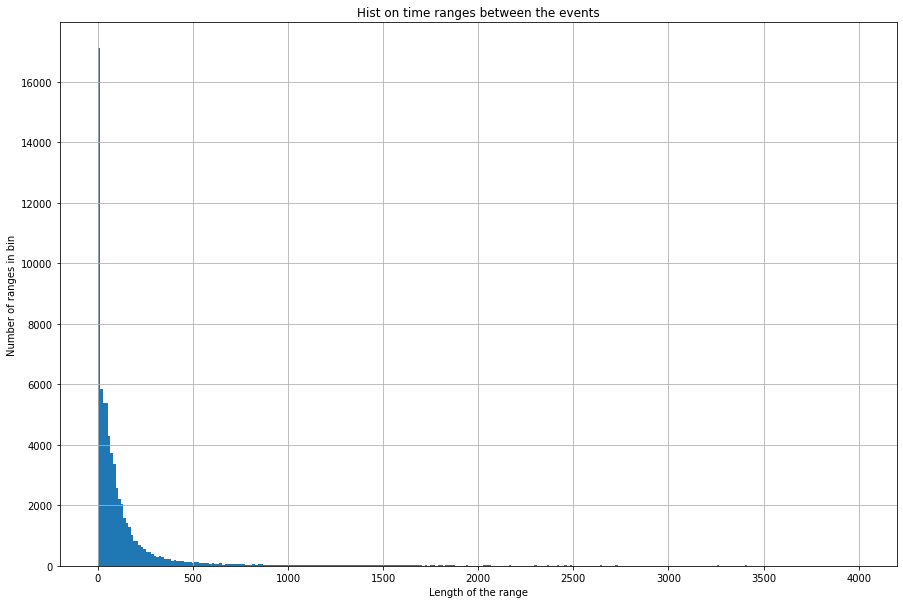

In [22]:
sessions['gap_sec'].hist(bins=300, range=(0, 4000), figsize=(15,10))
plt.title('Hist on time ranges between the events')
plt.xlabel('Length of the range')
plt.ylabel('Number of ranges in bin')
plt.show()


In [23]:
sessions.gap_sec.describe().apply("{0:.2f}".format)

count      74197.00
mean       13172.22
std        89336.36
min            0.00
25%           16.00
50%           64.00
75%          167.00
max      2296195.00
Name: gap_sec, dtype: object

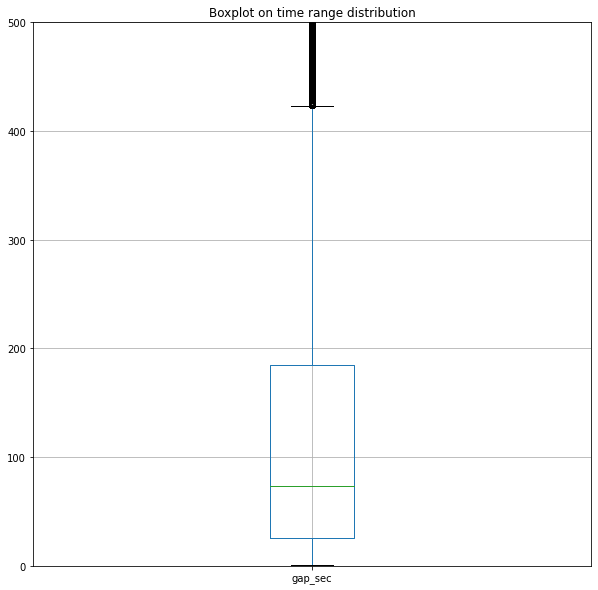

In [24]:
ax = sessions.query('gap_sec > 0').boxplot('gap_sec', figsize=(10,10))
ax.set_ylim(0, 500)
plt.title('Boxplot on time range distribution')
plt.show()

75% of cases lies under 185 seconds. This is 3 minutes between events. I assume that this is a correct threshold for session end. 


In [25]:
# Adding number of session for each user

threshold = sessions.query('gap_sec > 0').gap_sec.quantile(0.75)

session_counter = 1
for i in range(sessions.shape[0]):
    
    if sessions.loc[i,'rank'] == 1:
        session_counter = 1 # обнуляем счетчик
        sessions.loc[i, 'session_cnt'] = session_counter
        
    elif sessions.loc[i,'rank'] > 1:
        if sessions.loc[i, 'gap'] <= dt.timedelta(seconds=threshold):
            sessions.loc[i, 'session_cnt'] = session_counter
        elif sessions.loc[i, 'gap'] > dt.timedelta(seconds=threshold):
            session_counter += 1
            sessions.loc[i, 'session_cnt'] = session_counter


In [26]:
# Adding durattion of session. In order to do that we need put aside stat on the first event for each session

sessions['session_rank'] = sessions.groupby(['user_id', 'session_cnt'])['event_time'].rank(method='dense')


In [27]:
# Removing first events and summirizing time ranges

sessions_stat = sessions.query('session_rank != 1').groupby(['user_id', 'session_cnt']).agg(duration=('gap_sec','sum'), total_event=('user_id', 'count')).reset_index()

# For event counts adding one event as we have removed first event prefiously
sessions_stat['total_event'] = sessions_stat['total_event'] + 1


In [28]:
# Calculating session duration

sessions_avg = sessions_stat.groupby('user_id').agg(avg_duration=('duration','mean'))
sessions_stat = sessions_stat.merge(sessions_avg, on='user_id', how='left')

# merging with profiles
sessions_stat_fin = sessions_stat.groupby('user_id').agg({'session_cnt':'last', 'duration':'sum', 'avg_duration':'first', 'total_event':'sum'}).reset_index()


In [29]:
profiles = profiles.merge(sessions_stat_fin, on='user_id', how='left')


In [30]:
# Checking on NaN
for i in profiles.columns:
        print(i, ':', profiles[i].isna().sum())

user_id : 0
first_ts : 0
last_ts : 0
total_duration : 0
source : 0
target_action : 0
ta_count : 0
session_cnt : 167
duration : 167
avg_duration : 167
total_event : 167


There are users who have only one event, theuy show NaNs in new columns, we need to replace in on 1 for session count and 0 for session duration


In [31]:
profiles['session_cnt'] = profiles['session_cnt'].fillna(1)
profiles['total_event'] = profiles['total_event'].fillna(1)
profiles['duration'] = profiles['duration'].fillna(0)
profiles['avg_duration'] = profiles['avg_duration'].fillna(0)

## Step 3.2 Analysis

- Calculation retention rate on 7th and 14th day
- Average time in the application
- Average number of events
- Conversion into the target action


In [32]:
# retention rate

profiles['retention_7d'] = profiles.total_duration >= dt.timedelta(days=7)
profiles['retention_14d'] = profiles.total_duration >= dt.timedelta(days=14)


In [33]:
# At first we need to remove users which started to use application les than 7 of 14 days before our data file ends

threshold_14d = mobile_dataset.event_time.max() - dt.timedelta(days=14)
threshold_7d = mobile_dataset.event_time.max() - dt.timedelta(days=7)

print('Total 7d retention = ', 
        "{0:.2%}".format(sum(profiles
        .query('first_ts < @threshold_7d')
        .retention_7d) 
        / 
        profiles
        .query('first_ts < @threshold_7d')
        .shape[0]))

print('Total 14d retention = ', 
        "{0:.2%}".format(sum(profiles
        .query('first_ts < @threshold_14d')
        .retention_14d) 
        / 
        profiles
        .query('first_ts < @threshold_14d')
        .shape[0]))

print('Average time in product (in sec) = ', 
        "{0:.2f}".format(profiles.avg_duration.mean()))

print('Average events in product = ', 
        "{0:.2f}".format(profiles.total_event.mean()))

print('Conversion = ', 
        "{0:.2%}".format(sum(profiles.target_action)/profiles.shape[0])
        )


Total 7d retention =  18.61%
Total 14d retention =  11.45%
Average time in product (in sec) =  230.14
Average events in product =  15.37
Conversion =  22.85%


In [34]:
# Conduction cohort analysis by traffic source
cohorts = profiles[['user_id', 'first_ts', 'source', 'target_action']].copy()
cohorts['first_ts'] = cohorts['first_ts'].dt.date
cohort_stat = cohorts.pivot_table(index='first_ts', columns='source', values='target_action', aggfunc='sum').reset_index()
cohort_size = cohorts.pivot_table(index='first_ts', columns='source', values='user_id', aggfunc='nunique').reset_index()
cohort_stat.columns = ['ts', 'google_ta', 'other_ta', 'yandex_ta']
cohort_size.columns = ['ts', 'google_size', 'other_size', 'yandex_size']

cohort_stat = cohort_stat.merge(cohort_size, on='ts', how='left')
cohort_stat['google_conv'] = round((cohort_stat['google_ta'] / cohort_stat['google_size'] * 100), 2)
cohort_stat['other_conv'] = round((cohort_stat['other_ta'] / cohort_stat['other_size'] * 100), 2)
cohort_stat['yandex_conv'] = round((cohort_stat['yandex_ta'] / cohort_stat['yandex_size'] * 100), 2)


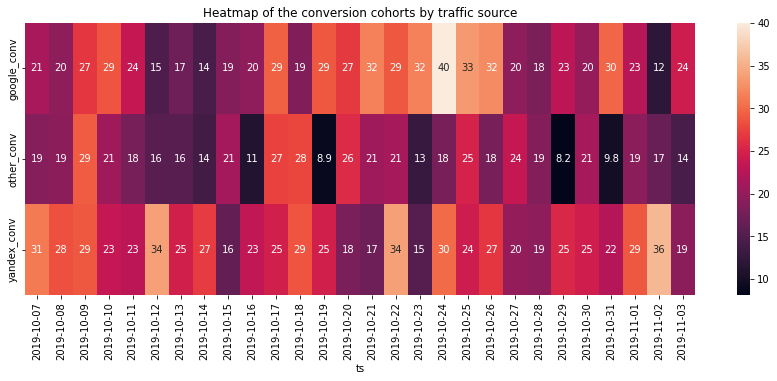

In [35]:
plt.figure(figsize=(15,5))
sns.heatmap(cohort_stat.set_index('ts')[['google_conv', 'other_conv', 'yandex_conv']].T, annot=True, linewidths=0)
plt.title('Heatmap of the conversion cohorts by traffic source')
plt.show()


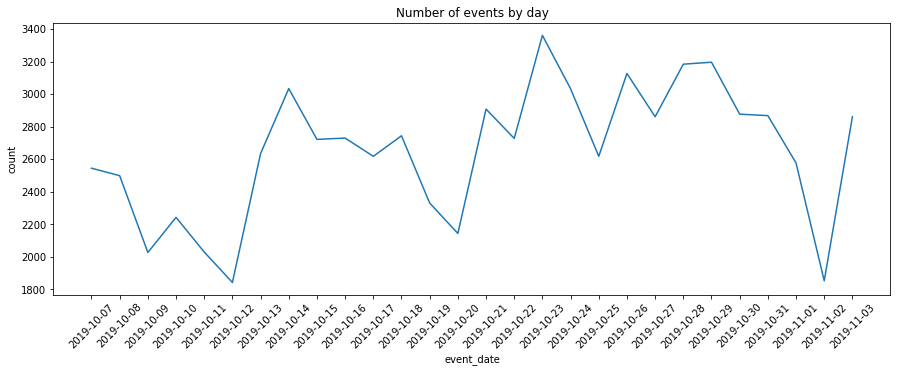

In [36]:
# Number of events in the application

mobile_dataset['event_date'] = mobile_dataset['event_time'].dt.date
actions_stat = mobile_dataset.groupby('event_date').agg(count=('user_id','count')).reset_index()
actions_stat

plt.figure(figsize=(15,5))
ax=sns.lineplot(data=actions_stat, x='event_date', y='count')
plt.xticks(rotation=45)
plt.xticks(actions_stat['event_date'])
plt.title('Number of events by day')
plt.show()

## Step 4. Checking hypothesises 

- Traffic sources influece conversion
- Traffic sources influence retention

In [37]:
# Preparing z_test function 


def z_test(share1, share2, s_size1, s_size2, alpha = .05):
    
    p1 = share1 / s_size1
    p2 = share2 / s_size2

    p_combined = ((share1 + share2) / 
              (s_size1 + s_size2))

    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/s_size1 + 1/s_size2))

    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2

    if p_value < alpha:
        print('p-value is: ', p_value, 'the differencs is significant')
    else: 
        print('p-value is: ', p_value, 'the difference if NOT significant')



In [38]:
# Н0 - There is no difference in conversion
# Н1 - There is difference in conversion


def check_for(feature, source):
    sources_comb = list(combinations(profiles[source].unique(),2)) # Bonferroni amendment
    alpha_var = .05 / len(sources_comb)
    for i in sources_comb:
    
        source1 = i[0]
        source2 = i[1]
        sample_1 = profiles.query('source == @source1')
        sample_2 = profiles.query('source == @source2')
    
        share1 = sum(sample_1[feature]) 
        share2 = sum(sample_2[feature]) 

        print('For',i[0], 'converted :', share1, 'from:', sample_1.shape[0])
        print('For',i[1], 'converted :', share2, 'from:', sample_2.shape[0])
        print(z_test(share1, share2, sample_1.shape[0], sample_2.shape[0], alpha=alpha_var))
        print()
    




In [39]:
check_for('target_action', 'source')

For other converted : 228 from: 1230
For yandex converted : 478 from: 1934
p-value is:  4.7142597613403225e-05 the differencs is significant
None

For other converted : 228 from: 1230
For google converted : 275 from: 1129
p-value is:  0.0005640941887214979 the differencs is significant
None

For yandex converted : 478 from: 1934
For google converted : 275 from: 1129
p-value is:  0.8244316027993777 the difference if NOT significant
None



In [40]:
# Н0 - There is no difference in 7d retention
# Н1 - There is difference in 7d retention

check_for('retention_7d', 'source')

For other converted : 193 from: 1230
For yandex converted : 283 from: 1934
p-value is:  0.4170265299571527 the difference if NOT significant
None

For other converted : 193 from: 1230
For google converted : 155 from: 1129
p-value is:  0.17946079069880305 the difference if NOT significant
None

For yandex converted : 283 from: 1934
For google converted : 155 from: 1129
p-value is:  0.49056514647426575 the difference if NOT significant
None



In [41]:
# Н0 - There is no difference in 14 day retention
# Н1 - There is difference in 14 day retention

check_for('retention_14d', 'source')

For other converted : 89 from: 1230
For yandex converted : 114 from: 1934
p-value is:  0.1333896286235292 the difference if NOT significant
None

For other converted : 89 from: 1230
For google converted : 60 from: 1129
p-value is:  0.05531918850452655 the difference if NOT significant
None

For yandex converted : 114 from: 1934
For google converted : 60 from: 1129
p-value is:  0.503433310173885 the difference if NOT significant
None



In [42]:
# Н0 - There is NO difference between Yandex and Google in conversion
# Н1 - There is difference between Yandex and Google in conversion
sample_1 = profiles.query('source == "yandex"')
sample_2 = profiles.query('source == "google"')

share1 = sum(sample_1['target_action']) 
share2 = sum(sample_2['target_action']) 
z_test(share1, share2, sample_1.shape[0], sample_2.shape[0])


p-value is:  0.8244316027993777 the difference if NOT significant


## Step 5. Segmentation

At first we need to define what columns will go to the segmentation

In [43]:
df_segmentation = profiles[['source', 'ta_count', 'session_cnt', 'duration', 'avg_duration', 'total_event']]
df_segmentation = pd.get_dummies(df_segmentation, columns=['source'])
df_segmentation.head()

,ta_count,session_cnt,duration,avg_duration,total_event,source_google,source_other,source_yandex
0,0,7.0,2025.0,289.285714,35.0,0,1,0
1,11,19.0,3234.0,215.600000,65.0,0,0,1
2,0,4.0,512.0,170.666667,9.0,0,0,1
3,0,12.0,670.0,95.714286,25.0,1,0,0
4,3,3.0,173.0,57.666667,7.0,0,0,1


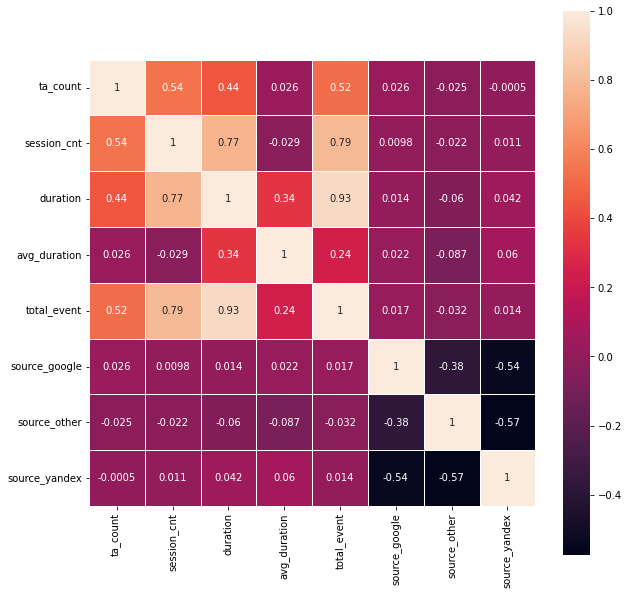

In [44]:
cm = df_segmentation.corr() 

plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, square=True, linewidths=1)
ax.set_ylim(
    7, 0
)  
plt.show()

Total event correlates a lot with general duration in the application. We need to remove one column
And to define proper number of segments

In [45]:

df_segmentation = df_segmentation.drop(columns=['total_event'])


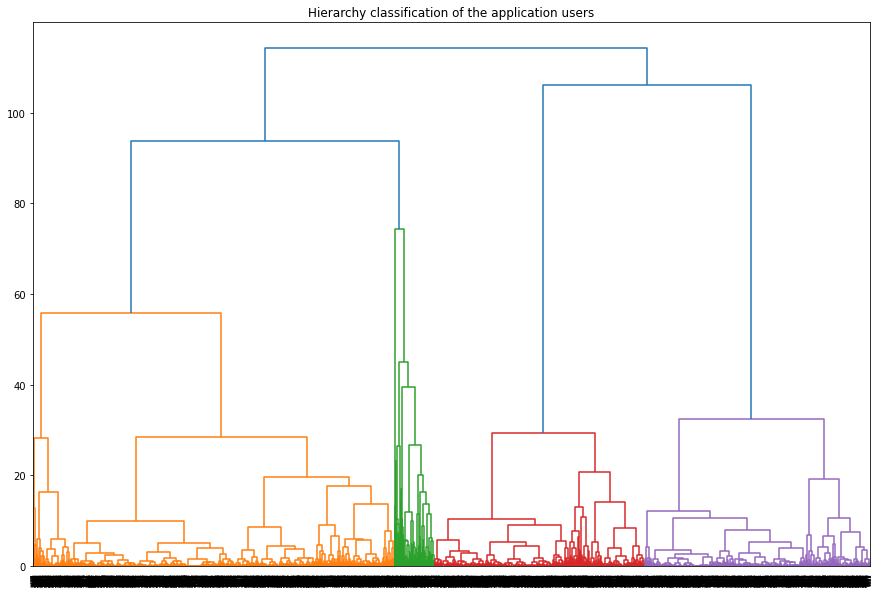

In [46]:
scaler = StandardScaler()
scaler.fit(df_segmentation)

X_sc = scaler.fit_transform(df_segmentation)
linked = linkage(X_sc, method = 'ward') 
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchy classification of the application users')
plt.show() 

Lets leave 4 segments for a while

In [47]:

km = KMeans(n_clusters=4, random_state=0)
labels = km.fit_predict(X_sc)

df_segmentation['cluster_km'] = labels
df_segmentation['target_action'] = profiles['target_action']
df_segmentation['retention_7d'] = profiles['retention_7d']
df_segmentation['retention_14d'] = profiles['retention_14d']
 

In [48]:
df_segmentation.head()

,ta_count,session_cnt,duration,avg_duration,source_google,source_other,source_yandex,cluster_km,target_action,retention_7d,retention_14d
0,0,7.0,2025.0,289.285714,0,1,0,0,False,True,True
1,11,19.0,3234.0,215.600000,0,0,1,1,True,True,True
2,0,4.0,512.0,170.666667,0,0,1,1,False,False,False
3,0,12.0,670.0,95.714286,1,0,0,2,False,True,False
4,3,3.0,173.0,57.666667,0,0,1,1,True,False,False


In [49]:
df_segmentation.cluster_km.value_counts(normalize=True)

1    0.447939
0    0.285115
2    0.260657
3    0.006289
Name: cluster_km, dtype: float64

No we see that one segment has less than 1% of the users. Let's focus on 3 segments

In [50]:

km = KMeans(n_clusters=3, random_state=0)
labels = km.fit_predict(X_sc)

df_segmentation['cluster_km'] = labels

In [51]:
df_segmentation.groupby('cluster_km').agg({'cluster_km':'count'})

,cluster_km
cluster_km,
0,1230
1,1934
2,1129


ta_count
            ta_count
cluster_km          
0           0.856911
1           1.052223
2           1.275465


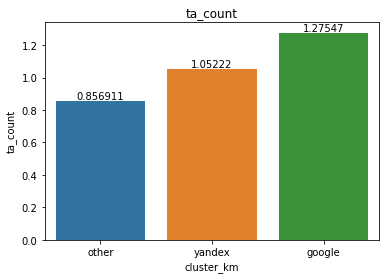



session_cnt
            session_cnt
cluster_km             
0              4.163415
1              4.534126
2              4.569531


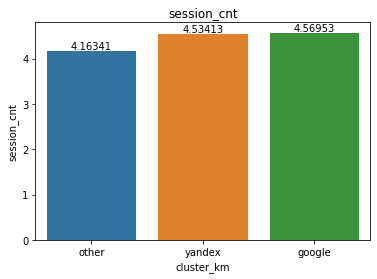



duration
              duration
cluster_km            
0           579.727642
1           759.491727
2           730.006200


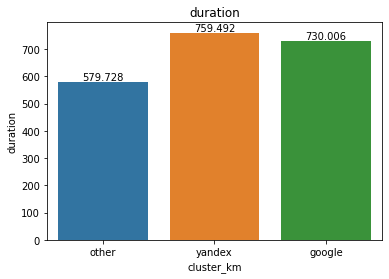



avg_duration
            avg_duration
cluster_km              
0             199.095206
1             245.069916
2             238.369642


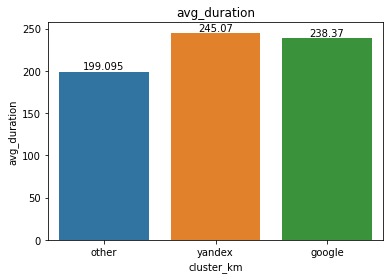



source_google
cluster_km          0       1       2
source_google                        
0              1230.0  1934.0     NaN
1                 NaN     NaN  1129.0


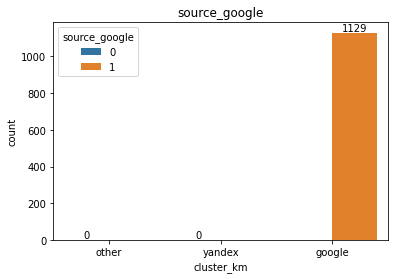



source_other
cluster_km         0       1       2
source_other                        
0                NaN  1934.0  1129.0
1             1230.0     NaN     NaN


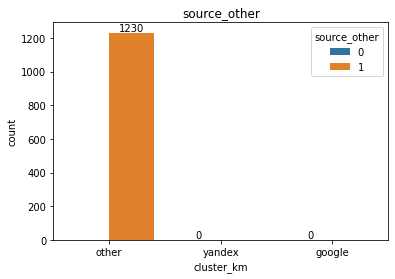



source_yandex
cluster_km          0       1       2
source_yandex                        
0              1230.0     NaN  1129.0
1                 NaN  1934.0     NaN


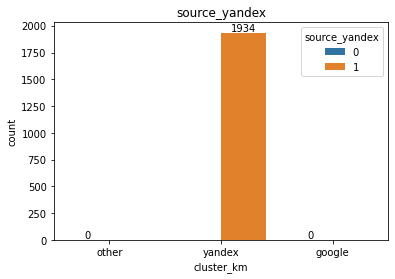

In [52]:
for i in df_segmentation.drop(columns=['cluster_km', 'target_action', 'retention_7d', 'retention_14d']).columns:
    print(i)
    if len(df_segmentation[i].unique()) < 5:
        table = df_segmentation.pivot_table(values='session_cnt', index=i, columns='cluster_km', aggfunc='count')
        print(table)
        ax = sns.barplot(x=df_segmentation.cluster_km, y=df_segmentation[i], hue=df_segmentation[i], estimator=np.count_nonzero)
        for container in ax.containers:
            ax.bar_label(container)
        plt.ylabel('count')
        ax.set_xticklabels( ('other', 'yandex', 'google') )
        plt.title(i)
        plt.show()
        print()
        print()
    else: 
        table = df_segmentation.groupby('cluster_km').agg({i:'mean'})
        print(table)
        ax = sns.barplot(data=table, x=table.index, y=i)
        for container in ax.containers:
            ax.bar_label(container)
        plt.title(i)
        ax.set_xticklabels( ('other', 'yandex', 'google') )
        plt.show()
        print()
        print()

In [53]:
# Analysing conversion and retention

segments_stat = df_segmentation.groupby('cluster_km').agg({'target_action':'sum', 
                                                           'retention_7d':'sum', 
                                                           'retention_14d':'sum',
                                                           'session_cnt':'count'}).reset_index()
segments_stat

,cluster_km,target_action,retention_7d,retention_14d,session_cnt
0,0,228,193,89,1230
1,1,478,283,114,1934
2,2,275,155,60,1129


In [54]:
segments_stat['target_action'] = (segments_stat.target_action / segments_stat.session_cnt)#.apply("{0:.2f}".format)
segments_stat['retention_7d'] = (segments_stat.retention_7d / segments_stat.session_cnt)#.apply("{0:.2f}".format)
segments_stat['retention_14d'] = (segments_stat.retention_14d / segments_stat.session_cnt)#.apply("{0:.2f}".format)
segments_stat

,cluster_km,target_action,retention_7d,retention_14d,session_cnt
0,0,0.185366,0.156911,0.072358,1230
1,1,0.247156,0.146329,0.058945,1934
2,2,0.243578,0.137290,0.053144,1129


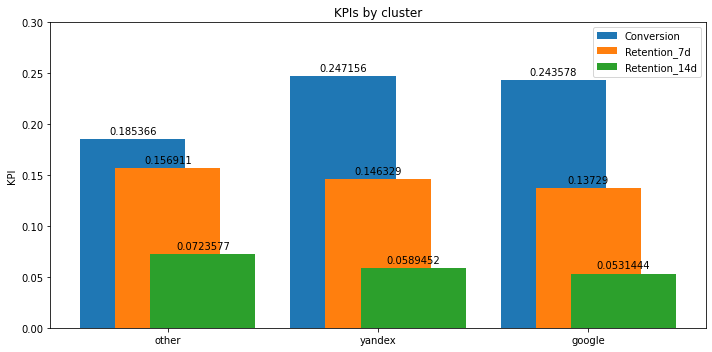

In [55]:


x = np.arange(len(segments_stat.cluster_km))  # the label locations
width = 0.5  # the width of the bars


fig, ax = plt.subplots()
fig.set_figheight(5)
fig.set_figwidth(10)

rects1 = ax.bar(x - width/3, segments_stat.target_action, width, label='Conversion')
rects2 = ax.bar(x , segments_stat.retention_7d, width, label='Retention_7d')
rects3 = ax.bar(x + width/3, segments_stat.retention_14d, width, label='Retention_14d')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('KPI')
ax.set_title('KPIs by cluster')
ax.set_xticks(x)
ax.set_xticklabels( ('other', 'yandex', 'google') )
ax.set_ylim(0, 0.3)

ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()


In [56]:
# Н0 - average number of target action between users from yandex and google is the same 
# Н1 - average number of target action between users from yandex and google is NOT the same 

def average_test(dataA, dataB):
# сначала проверим обе выборки с помощью критерия Шапиро-Уилка
    alpha = .05 

    p_value_1 = st.shapiro(dataA)[1]
    p_value_2 = st.shapiro(dataB)[1]
    
    if p_value_1 < alpha and p_value_2 < alpha:
        result = st.ttest_ind(dataA, dataB)
        print('Distribution is normal. ttest p-value:', result.pvalue)
        if result.pvalue < alpha:
            print('Difference if significant')
        else: 
            print('Difference if NOT significant')
    else:
        result = st.mannwhitneyu(dataA, dataB)
        print('Distribution is NOT normal. Utest p-value:', result.pvalue)
        if result.pvalue < alpha:
            print('Difference if significant')
        else: 
            print('Difference if NOT significant')




In [57]:
dataA = df_segmentation.query('cluster_km == 1')
dataB = df_segmentation.query('cluster_km == 2')

average_test(dataA.ta_count, dataB.ta_count)

Distribution is normal. ttest p-value: 0.25968114496404565
Difference if NOT significant


Conclusions:
Our 3  segments were divided by traffic sources:
- Segment 0: Came from the source other, rarely goes to the target action in principle, generates the least events and spends less time in the application.
- Segment 1: Came from Yandex - on second place in terms of the number of targeted actions and on first place in terms of the average duration of sessions.
- Segment 2: came from Google - on first place in terms of the number of targeted actions. However, the gap between it and segment 1 is not significant.

- Of all three segments, those who came from Google and Yandex show the highest conversion to the target action


## Conclusions:

- 3/4 of the described cases lie bellow 185 seconds. It's +- 3 minutes. As part of the study, this boundary is set as the session boundary
- Judging by the heat map, in Google, the highest conversion is observed for cohorts that came on the 10th and 25th, when many companies pay salaries. For other sources, the cohorts are more homogeneous.
- The same goes for the number of events in the application
- Traffic source 'other' differs from google and yandex in terms of conversion
- The hypothesis about the difference in conversion between Google and Yandex as traffic sources was not confirmed
- The traffic source does not affect the retention at all
- Segmentation also separated users based on traffic source.
- Conversion among those who came from other traffic sources is different from the conversion among those who came from Yandex and Google.
- Those who came from Google demonstrate high performance in the target action, but the gap between them and Yandex is insignificant
